In [7]:
import pandas as pd
import numpy as np
import os
import json
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch

from src.utils import get_params, get_data
from src.preprocessing import clean_data, get_features
from src.descriptives import plot_missings, plot_ages, plot_wordcloud
from src.training import run_finetuning

In [8]:
os.listdir("data")

['tokens.yml', 'outputs', 'entities.json']

## 1) Setup (getting and processing data, setting device and seed, etc...)

In [9]:
raw_tokens = get_data("data/tokens.yml")
raw_data = get_data("data/entities.json")
params = get_params('conf/params.yaml')

torch.manual_seed(params['seed'])
torch.cuda.manual_seed(params['seed'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# reshape the tokens dictionary
tokens = {key: value['start'] for key, value in raw_tokens.items()}

In [84]:
# clean the data
data = clean_data(raw_data, tokens)

## 2) Statistiques descriptives

In [12]:
tokens

{'age': 'Ⓐ',
 'birth_date': 'Ⓑ',
 'civil_status': 'Ⓒ',
 'education_level': 'Ⓓ',
 'employer': 'Ⓔ',
 'firstname': 'Ⓕ',
 'link': 'Ⓗ',
 'lob': 'Ⓘ',
 'maiden_name': 'Ⓙ',
 'nationality': 'Ⓚ',
 'observation': 'Ⓛ',
 'occupation': 'Ⓜ',
 'surname': 'Ⓞ',
 'surname_household': 'Ⓟ'}

In [13]:
data

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname,surname_household
0,25,NaN,Garçon,NaN,NaN,Cyrille,NaN,NaN,NaN,française,NaN,menuisier,Breton,NaN
1,30,NaN,Garçon,NaN,NaN,Auguste,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Ferazzi
2,24,NaN,Garçon,NaN,NaN,Pierre,NaN,NaN,NaN,Piémontaise,NaN,vitrier,NaN,Machol
3,48,NaN,Homme,NaN,NaN,Alexandre,NaN,NaN,NaN,française,NaN,prop,NaN,Desbois
4,30,NaN,NaN,NaN,NaN,Zélie,sa,NaN,NaN,française,NaN,prop,Vignat,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25440,NaN,1869,NaN,NaN,NaN,Marie,chef,Pailharès,NaN,idem,NaN,NaN,NaN,Chameton-Dideron
25441,NaN,1863,NaN,NaN,Cara,Marie,chef,St,NaN,idem,NaN,ouv,NaN,Ode
25442,NaN,1886,NaN,NaN,Baretto,Nello,chef,Castel,NaN,italienne,NaN,manoeuvre,NaN,Berni
25443,NaN,1887,NaN,NaN,NaN,Annunziata,épouse,idem,NaN,idem,NaN,NaN,Berni-Laureti,NaN


In [14]:
missings = data.isna().sum(axis=0).sort_values(ascending=False)
print(missings)
print((missings / len(data)) * 100)

education_level      25075
maiden_name          25075
observation          24473
employer             22164
surname_household    19435
birth_date           17731
lob                  15839
civil_status         14370
nationality          11761
occupation            8896
age                   8639
surname               5916
link                  4339
firstname              144
dtype: int64
education_level      100.000000
maiden_name          100.000000
observation           97.599202
employer              88.390828
surname_household     77.507478
birth_date            70.711864
lob                   63.166500
civil_status          57.308076
nationality           46.903290
occupation            35.477567
age                   34.452642
surname               23.593220
link                  17.304088
firstname              0.574277
dtype: float64


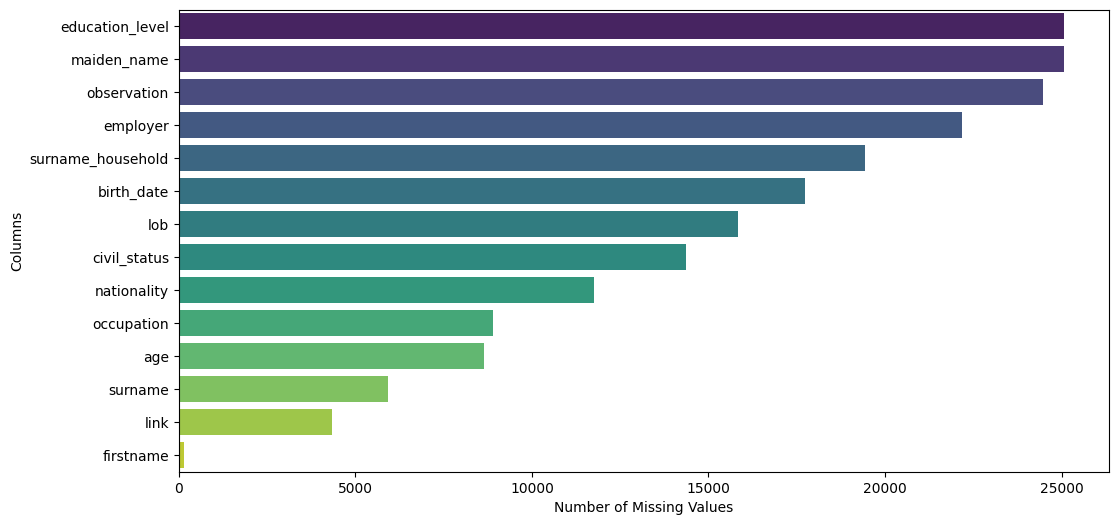

In [15]:
from src.descriptives import plot_missings
plot_missings(missings)

In [46]:
# verification de la nationalité
(
    data["nationality"].dropna().str.lower().value_counts(ascending=False)
    * 100
    / len(data["nationality"].dropna())
).head(10)

nationality
française     60.214811
idem          33.453508
français       2.831606
francaise      2.080517
polonaise      0.398077
id             0.172750
espagnole      0.112663
belge          0.105152
polonais       0.067598
portugaise     0.060087
Name: count, dtype: float64

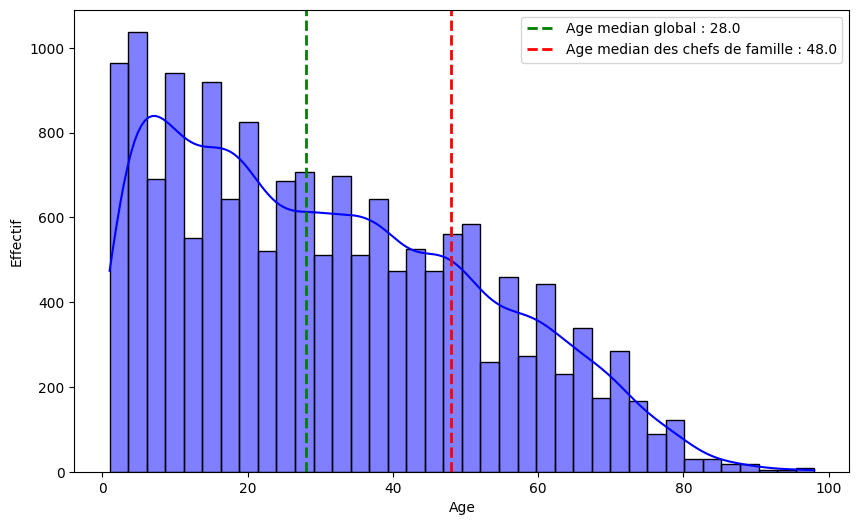

In [39]:
plot_ages(data)

In [50]:
# etude de la parité
round(data["civil_status"].dropna().value_counts() * 100 / len(data["civil_status"].dropna()), 2)

civil_status
Garçon    26.38
Fille     26.37
Homme     20.00
Femme     19.74
Veuve      4.78
Veuf       2.73
Name: count, dtype: float64

In [60]:
# etude du lien de parenté
data["link"].str.lower().str.strip().value_counts().head(10)

link
chef          4516
sa            2802
leur          2263
idem          2152
fils          1546
fille         1446
femme         1215
épouse         905
son            685
domestique     532
Name: count, dtype: int64

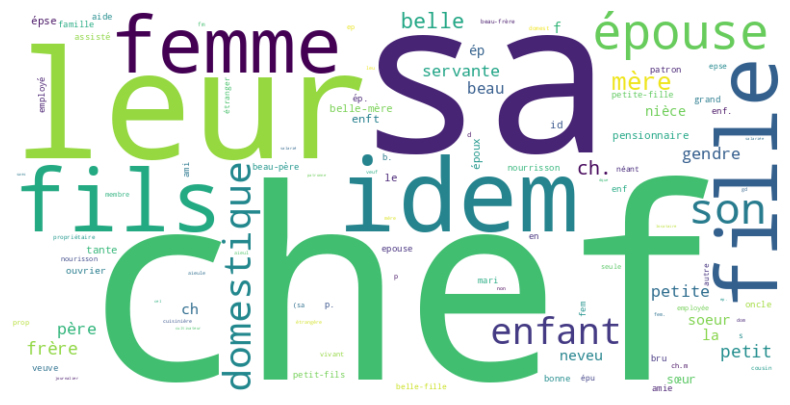

In [90]:
plot_wordcloud(data, "link")

In [93]:
len(data[(data['link'].str.lower() == 'chef') & (~data['surname_household'].isna())])

3737

In [38]:
import importlib
import src.descriptives

importlib.reload(src.descriptives)

<module 'src.descriptives' from '/home/onyxia/work/NLP/src/descriptives.py'>

In [17]:
X, y = get_features(data)
X, X.shape, y.shape

(array(['25 Garçon Cyrille française menuisier Breton',
        '30 Garçon Auguste Piémontaise vitrier',
        '24 Garçon Pierre Piémontaise vitrier', ...,
        '1886 Baretto Nello chef Castel italienne manoeuvre',
        '1887 Annunziata épouse idem idem Berni-Laureti',
        '1914 Primo fils idem idem Berni'], dtype='<U79'),
 (25075,),
 (25075,))

In [23]:
print(f"Nombre et proportion de chefs de ménages dans l'échantillon: {y.sum()} et {round((y.sum() / len(y)) * 100, 2)}%.")

Nombre et proportion de chefs de ménages dans l'échantillon: 5640 et 22.49%.


## 3) Experiments

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=params['test_size'], stratify=y, random_state=params['seed']
    )

Nous allons montrer un exemple d'utilisation de notre code (dont l'implémentation complète est réalisée à partir du script `main.py`).
Nous réalisons ici le finetuning de CamemBERT base, avec implémentation d'une procédure d'early-stopping.

### Example: CamemBERT finetuning

In [6]:
from conf.config import models

tokenizer_class, model_class = models['almanach/camembert-base']
tokenizer = tokenizer_class.from_pretrained(model_name)
model = model_class.from_pretrained(
    model_name, num_labels=len(np.unique(y_train))
    )
model.to(device)
model_name = model_name.split('/')[-1]
run_finetuning(
    tokenizer, model, model_name, params,
    X_train, X_val, y_train, y_val,
    es=True, device
)

{'flaubert/flaubert_base_cased': [transformers.models.flaubert.tokenization_flaubert.FlaubertTokenizer,
  transformers.models.flaubert.modeling_flaubert.FlaubertForSequenceClassification],
 'flaubert/flaubert_base_uncased': [transformers.models.flaubert.tokenization_flaubert.FlaubertTokenizer,
  transformers.models.flaubert.modeling_flaubert.FlaubertForSequenceClassification],
 'almanach/camembert-base': [transformers.models.camembert.tokenization_camembert.CamembertTokenizer,
  transformers.models.camembert.modeling_camembert.CamembertForSequenceClassification],
 'almanach/camembert-large': [transformers.models.camembert.tokenization_camembert.CamembertTokenizer,
  transformers.models.camembert.modeling_camembert.CamembertForSequenceClassification],
 'google-bert/bert-base-cased': [transformers.models.bert.tokenization_bert.BertTokenizer,
  transformers.models.bert.modeling_bert.BertForSequenceClassification],
 'google-bert/bert-base-uncased': [transformers.models.bert.tokenization_be

On peut enfin afficher les métriques et quelques plots en allant chercher ces derniers à l'endroit où la fonction `run_finetuning`les a sauvegardé :

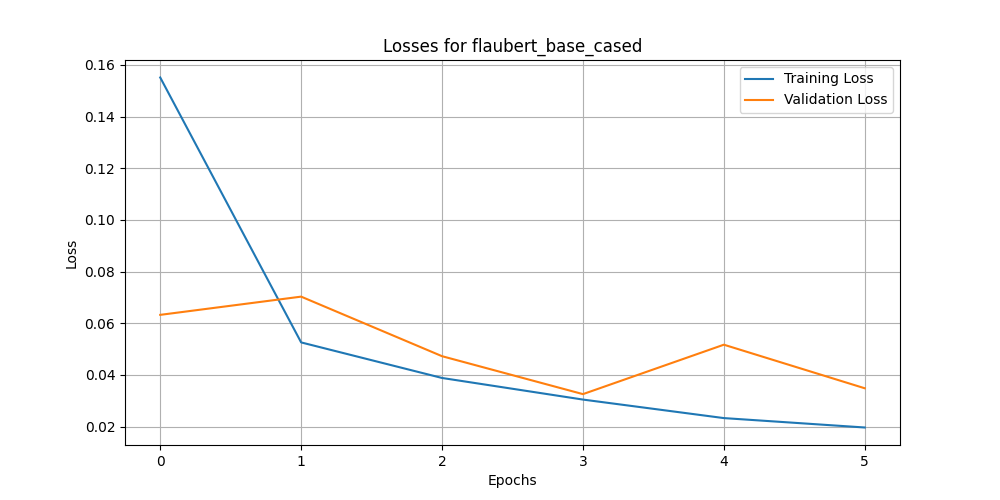

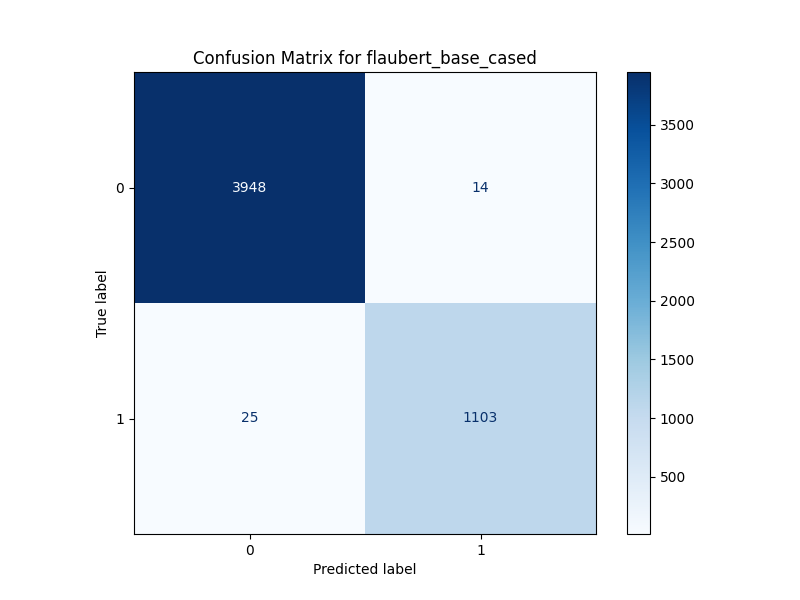

In [11]:
img = Image.open('assets/plots/losses/camembert-base_es.png')
img.show()

img = Image.open('assets/plots/confusion/camembert-base_es.png')
img.show()

In [10]:
classif_report = get_data("data/outputs/camembert-base_es/classif_report.json")
for label, metrics in classif_report.items():
    if isinstance(metrics, dict):
        print(f"Class {label}:")
        for metric_name, metric_value in metrics.items():
            print(f"  {metric_name.capitalize()}: {metric_value:.2f}")
    else:
        print(f"{label.capitalize()}: {metrics:.2f}")
    print()

Class 0:
  Precision: 0.99
  Recall: 1.00
  F1-score: 1.00
  Support: 3962.00

Class 1:
  Precision: 0.99
  Recall: 0.98
  F1-score: 0.98
  Support: 1128.00

Accuracy: 0.99

Class macro avg:
  Precision: 0.99
  Recall: 0.99
  F1-score: 0.99
  Support: 5090.00

Class weighted avg:
  Precision: 0.99
  Recall: 0.99
  F1-score: 0.99
  Support: 5090.00

